# CNN des chiffres et des lettres

Satger Aurélien et Dauliac Julien

Mode dev:

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import librairies 📚

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras

In [ ]:
import datetime

cache_dir = ".cache" 

def get_directory(name, cache_dir=cache_dir):
    return f"{cache_dir}/{name}"

def get_asset_directory(name):
    return f"assets/{name}"

def get_log_directory(name, cache_dir=cache_dir):
    directory_name = get_directory(name)
    log_dir = f"{directory_name}/log"
    return log_dir

def get_fit_directory(name, cache_dir=cache_dir):
    directory_name = get_directory(name)
    log_dir = f"{directory_name}/fit"
    return log_dir

def get_project_name(section_label):
    return f"CNN-{section_label}"

In [ ]:
import string
alphabet = list(string.ascii_lowercase)
print(alphabet)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Chargement des données 💾

In [ ]:
%%time
letters_train = pd.read_csv(
    'https://www.labri.fr/perso/zemmari/datasets/emnist/emnist-letters-train.csv',
    header=None
)

letters_test = pd.read_csv(
    'https://www.labri.fr/perso/zemmari/datasets/emnist/emnist-letters-test.csv',
    header=None
)

CPU times: user 4.19 s, sys: 1.67 s, total: 5.86 s
Wall time: 2min 3s


In [ ]:
letters_train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
letters_test.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Preprocess des données 🧮

In [ ]:
def shape_data(x):
    x = np.reshape(x, (x.shape[0], 28, 28))
    
    x = x.astype('float32')
    x  = x / 255
    return x

def categorize_data(y, categorical_count):
    return keras.utils.to_categorical(y, categorical_count)

def preprocess_data(x, y, categorical_count=26):    
    x = shape_data(x)
    y = categorize_data(y, categorical_count)
    return x, y

def preprocess_data_instruction(letters, categorical_count=26):
    """
    It takes the dataframe of letters and returns the x and y data in the format that we need for our
    neural network
    
    :param letters: the dataframe containing the data
    :return: x is the array of images and y is the array of labels
    """

    x = np.array(letters.iloc[:, 1:785])
    y = np.array(letters.iloc[:, 0])
    y = y - 1
    return x, y

In [ ]:
(x_train_unprocessed, y_train_unprocessed) = preprocess_data_instruction(letters_train)
(x_test_unprocessed, y_test_unprocessed) = preprocess_data_instruction(letters_test)
(x_train, y_train) = preprocess_data(x_train_unprocessed, y_train_unprocessed)
(x_test, y_test) = preprocess_data(x_test_unprocessed, y_test_unprocessed)

In [ ]:
def print_shape(x_train, y_train, x_test, y_test):
    print('Train: x=%s, y=%s' % (x_train.shape, y_train.shape))
    print('Test: x=%s, y=%s' % (x_test.shape, y_test.shape))

In [ ]:
print_shape(x_train, y_train, x_test, y_test)

Train: x=(88800, 28, 28), y=(88800, 26)
Test: x=(14800, 28, 28), y=(14800, 26)


## Exploration 🧭

In [ ]:
def plot_9_random_images(x, y, references=alphabet):
    """
    It plots 9 random images from the dataset
    
    :param x: the images
    :param y: the labels for the images
    """
    
    _, axes = plt.subplots(3, 3, figsize=(7, 7))

    for i in range(9):
        ax = axes[i // 3][i%3]
        idx = np.random.randint(0, len(x))
        ax.imshow(x[idx])
        ax.set_title(references[np.argmax(y[idx])])

    plt.show()

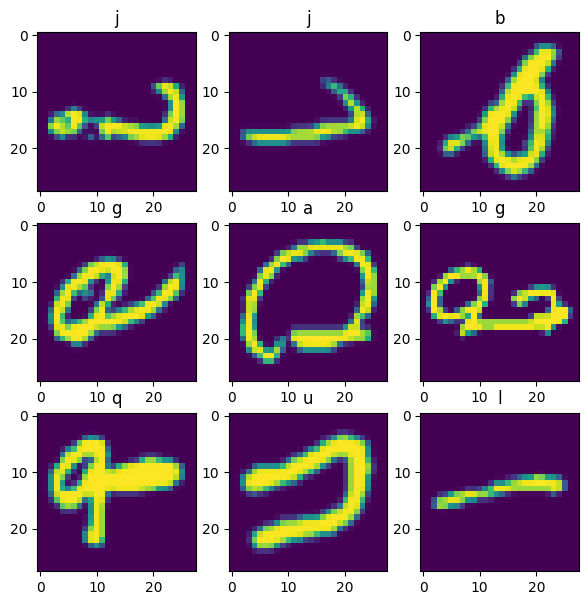

In [ ]:
plot_9_random_images(x_train, y_train)

Nous allons afficher et comparer nos données de test et nos données d'entrainement:

In [ ]:
def plot_train_vs_test(y_train, y_test, labels=alphabet):
    _, ax = plt.subplots(figsize=(9, 5))
    shape_len = len(labels)
    ax.bar(range(shape_len), y_train.sum(axis=0), label="train")
    ax.bar(range(shape_len), y_test.sum(axis=0), label="test")
    ax.legend()
    ax.set_xticks(range(shape_len))
    ax.set_xticklabels(labels)
    ax.set_title("Nombre de données y par lettres")

    ax.legend()
    plt.show()

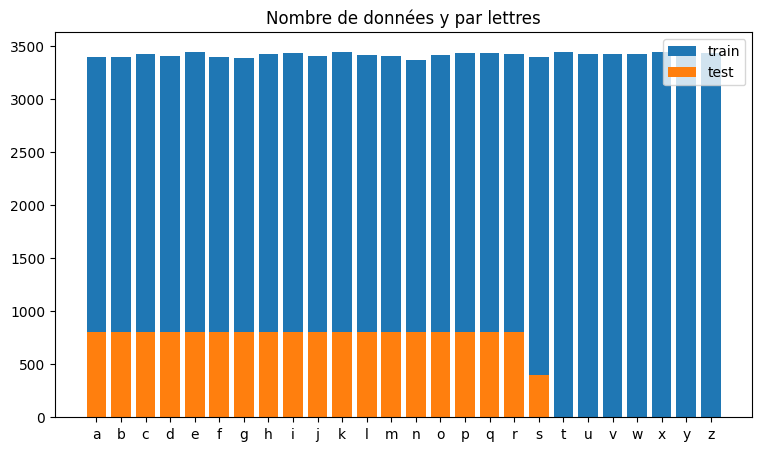

In [ ]:
plot_train_vs_test(y_train, y_test)

Nous allons donc faire un fix en entraînant jusqu'au `s`
Nous ne serons pas capable de reconnaitre les lettres allant de `s` à `z`.
 
Cependant le jeu de test et d'entrainement étant fourni dans le sujet, nous choisissons de les garder indépendantes.
On retire donc les données non annotées.
 
On peut également noter un manque de données de tests pour le `s`. Notre modèle reconnaitra donc moins bien les `s` des autres lettres.

Il aurait également été possible d'alimenter notre jeu de test avec des données du jeux d'entrainement. Cela aurait été au risque de biaiser notre jeu d'entrainement ou de sortir de la consigne du sujet.

In [ ]:
def fixed_data(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_tests=y_test,
    alphabet=alphabet
):
    letter_s_index = 18
    alphabet_fixed = alphabet[0:letter_s_index+1]
    y_test_fixed = y_test[:, 0:letter_s_index+1]
    y_train_fixed = y_train[:, 0:letter_s_index+1]
    return x_train, y_train_fixed, x_test, y_test_fixed, alphabet_fixed

In [ ]:
x_train_fixed, y_train_fixed, x_test_fixed, y_test_fixed, alphabet_fixed = fixed_data()

In [ ]:
def print_train_shape(x_train, y_train):
    if x_train.shape[0] == y_train.shape[0]:
        print("x_train " + str(x_train.shape[0]) + " == y_train " + str(y_train.shape[0]))
    elif x_train.shape[0] < y_train.shape[0]:
        print("x_train " + str(x_train.shape[0]) + " < y_train " + str(y_train.shape[0]))
    else:
        print("x_train " + str(x_train.shape[0]) + " > y_train " + str(y_train.shape[0]))

nos données d'entrainement doivent avoir la même quantitée de données.

In [ ]:
print_train_shape(x_train_fixed, y_train_fixed)

x_train 88800 == y_train 88800


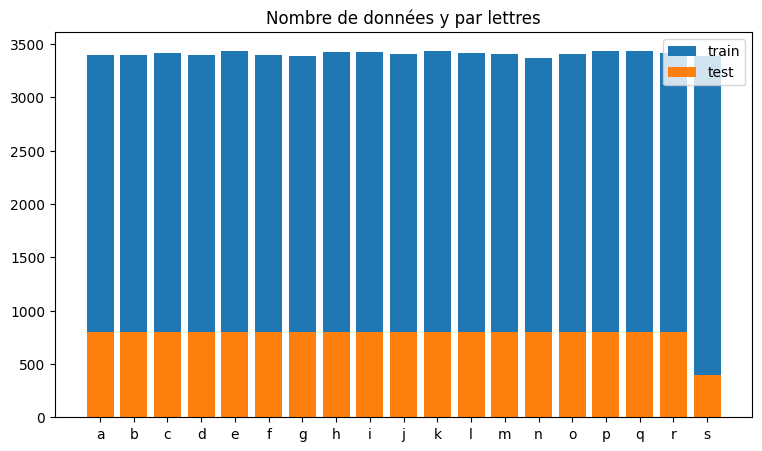

In [ ]:
plot_train_vs_test(y_train_fixed, y_test_fixed, alphabet_fixed)

In [ ]:
print_train_shape(x_train, y_train)

x_train 88800 == y_train 88800


On peut voir que nos jeux de test et d'entrainement sont désormais proportionnés 🎊.

## Fit un modèle simple 🚀

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

simple_model_section_label = "fit-simple-model"
simple_model_log_dir = get_log_directory(simple_model_section_label)

In [ ]:
num_pixels = x_train_fixed.shape[1] * x_train_fixed.shape[2]
num_letters = y_train_fixed.shape[1]

In [ ]:
num_letters, num_pixels

(19, 784)

In [ ]:
def get_simple_model(num_pixels, num_letters):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
        
    model.add(Flatten())
    
    model.add(Dropout(0.25))
    model.add(Dense(num_pixels, input_dim=num_pixels, activation='sigmoid'))

    model.add(Dropout(0.25))

    # # Ajout d'une couche de classification en sortie avec 26 neurones (une pour chaque lettre de l'alphabet)
    model.add(Dense(num_letters, activation='softmax'))

    return model

In [ ]:
simple_model = get_simple_model(num_pixels, num_letters)
simple_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 784)               1606416   
                                                                 
 dropout_1 (Dropout)         (None, 784)               0         
                                                        

2022-12-29 12:43:15.094105: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-29 12:43:15.094331: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-29 12:43:15.094345: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2022-12-29 12:43:15.095083: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
simple_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
%%time

import tensorflow as tf
validation_split=0.2

simple_model_tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=simple_model_log_dir,
    histogram_freq=1)

simple_model.fit(
    x_train_fixed,
    y_train_fixed,
    epochs=15,
    batch_size=256,
    validation_split=validation_split,
    callbacks=[simple_model_tensorboard_callback])

Epoch 1/15
278/278 [==============================] - 12s 40ms/step - loss: 1.3639 - accuracy: 0.3253 - val_loss: 1.0347 - val_accuracy: 0.4908
Epoch 2/15
278/278 [==============================] - 11s 40ms/step - loss: 1.1008 - accuracy: 0.4170 - val_loss: 0.8897 - val_accuracy: 0.4960
Epoch 3/15
278/278 [==============================] - 12s 43ms/step - loss: 1.0328 - accuracy: 0.4409 - val_loss: 0.8123 - val_accuracy: 0.7582
Epoch 4/15
278/278 [==============================] - 12s 43ms/step - loss: 0.9789 - accuracy: 0.4625 - val_loss: 0.7973 - val_accuracy: 0.5268
Epoch 5/15
278/278 [==============================] - 11s 41ms/step - loss: 0.9287 - accuracy: 0.4755 - val_loss: 0.7510 - val_accuracy: 0.5546
Epoch 6/15
278/278 [==============================] - 12s 43ms/step - loss: 0.8880 - accuracy: 0.4888 - val_loss: 0.7324 - val_accuracy: 0.8095
Epoch 7/15
278/278 [==============================] - 11s 41ms/step - loss: 0.8488 - accuracy: 0.5010 - val_loss: 0.6644 - val_accuracy:

In [ ]:
def evaluate(model, x, y):
    score = model.evaluate(
        x_test_fixed,
        y_test_fixed,
        batch_size=128
    )

    print("Test loss:", score[0])
    print("Test accuracy:", score[1])

In [ ]:
evaluate(simple_model, x_test_fixed, y_test_fixed)

116/116 [==============================] - 1s 4ms/step - loss: 0.7115 - accuracy: 0.8167
Test loss: 0.7115131616592407
Test accuracy: 0.8166891932487488


In [ ]:
%load_ext tensorboard
%tensorboard --logdir {simple_model_log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 14490), started 0:05:31 ago. (Use '!kill 14490' to kill it.)

C'est pas trop mal, mais on peut faire mieux 🔝

On peut noter :
- la loss descend de manière constante,
- l'accuracy de validation augmente et diminue en suivant des cycles. On peut suposer que se limiter à un nombre d'épochs entre 2 et 6 peut être suffisant pour explorer les hyper paramètres dans un premier temps.

## 3 Benchmarks des hyper paramètres et variation d'architecture 🎛️

Nous allons utiliser `keras_tuner` pour tester plusieurs combinaisons d'hyper paramètres et de modèles.

Nous explorerons les pistes suivantes:
- variation des `kernel_size` des couches de convolution afin de tester différents niveaux de détails
- ajout d'une à 3 couche cachées `Dense`
- ajout de couches de `Dropout` ou non pour limiter le sur-apprentissage
    - variation des valeurs de dropout indépendantes pour chaques couches
- changement des fonctions d'activation

Edit:
- Après plusieurs essaies, nous avons pu constater que l'hyper paramètre `kernel_size` n'avait pas d'impacte positif sur la performance de notre modèle, nous garderons donc la même valeur que dans l'approche simple. Nous retirons l'option du `tunner` afin de limiter le nombre d'hyper paramètres à explorer.

In [ ]:
import keras_tuner

def build_model(hp, num_pixels=num_pixels, num_classes=num_letters):
    model = Sequential()
    
    model.add(Conv2D(
        32,
        kernel_size=(3,3), 
        activation='relu',
        input_shape=(28,28,1)
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
        
    model.add(Flatten())

    model.add(Dense(num_pixels, activation='sigmoid'))
    if hp.Boolean("dropout"):
        dropout = hp.Float(
            "dropout_first",
            min_value=0.1,
            max_value=0.9,
            sampling="log"
        )
        model.add(Dropout(dropout))

    for i in range(1, hp.Int("num_layers", 2, 4)):
        units=hp.Int(
            f"dense_{i}",
            min_value=num_classes,
            max_value=num_pixels,
            step=2
        )
        model.add(Dense(units, activation="sigmoid"))
        
        if hp.Boolean("dropout"):
            dropout = hp.Float(
                f"dropout_{i}",
                min_value=0.1,
                max_value=0.9,
                sampling="log"
            )
            model.add(Dropout(dropout))
    
    model.add(Dense(num_classes, activation='softmax'))
        
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    return model

In [ ]:
build_model(keras_tuner.HyperParameters())

In [ ]:
num_letters, num_pixels

(19, 784)

In [ ]:
tunner_section_label = "tunner-letter"
tunner_log_dir = get_log_directory(tunner_section_label)

In [ ]:
def get_tensorboard_callback(log_dir):
    return tf.keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=1)

#### Random tunner 🎲

In [ ]:
random_tunner_section_label = tunner_section_label + "-random"
random_tunner_log_dir = get_log_directory(random_tunner_section_label)
print(random_tunner_section_label, random_tunner_log_dir)

tunner-letter-random .cache/tunner-letter-random/log


In [ ]:
def get_random_tunner(section_label, objective="val_accuracy", max_trials=10):
    return keras_tuner.RandomSearch(
        hypermodel=build_model,
        objective=objective,
        max_trials=max_trials,
        seed=1,
        executions_per_trial=1,
        overwrite=True,
        directory=get_fit_directory(section_label),
        project_name=get_project_name(section_label))

#### Early stopping 🛑
- Nous utiliserons une fonction de callback `EarlyStopping` qui permet d'arrêter l'entrainement de manière précipitée.
Cette méthode nous aidera à trouver l'hyper paramètre d'`epochs` adapté à la situation
- Comme les cycles d'augmentation et de diminution de la validation se déroulent sur plus ou moins 3 cycles, nous définirons une patience de 4 épochs pour `EarlyStopping`
- Après plusieurs essaies, nous avons pu constater que l'`EarlyStopping` arrète toujours l'entrainement et ce dans un temps raisonable: `[5-40]` `epochs`. C'est une méthode efficasse qui nous permet de trouver un nombre d'`epochs` optimisé.

In [ ]:
def get_early_stoping():
    return keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=4)

In [ ]:
def benchmark(tunner, log_dir, x_train, y_train, epochs=4, early_stoping=True):
    early_stoping_callback = get_early_stoping()
    tensorboard_callback = get_tensorboard_callback(log_dir)
    callbacks = [tensorboard_callback, early_stoping_callback]
    tunner.search_space_summary()
    tunner.search(
        x_train,
        y_train,
        validation_split=0.2,
        epochs=epochs,
        callbacks=callbacks,
    )
    return tunner

- Nous utiliserons un faible nombre d'`epochs` (4) afin d'obtenir une idée des parametres a ajuster.

In [ ]:
random_tunner = get_random_tunner(random_tunner_section_label, max_trials=1)

In [ ]:
benchmark(
    random_tunner,
    random_tunner_log_dir,
    x_train_fixed,
    y_train_fixed,
    epochs=17)

Trial 1 Complete [00h 18m 07s]
val_accuracy: 0.6011261343955994

Best val_accuracy So Far: 0.6011261343955994
Total elapsed time: 00h 18m 07s
INFO:tensorflow:Oracle triggered exit


Analysons les résultats en utilisant tensorboard:

In [ ]:
%tensorboard --logdir {random_tunner_log_dir}

#### Hyperband tunner 🗺️

Cependant une exploration aléatoire des hyper paramètres n'est pas la solution la plus efficace dans notre cas.

C'est une solution qui repose sur la chance et utilise une recherche aveugle.

Nous allons utiliser un tunner hyperband qui permet d'apprendre des essaies précédents, contrairement à la recherche aléatoire qui est une recherche aveugle.

- Il existe également une approche bayesien de recherche des hyper paramètres qui cependant ne marche pas à cause des hyperparamètres de choix ou booleen. Nous exclurons cette possibilité. 

- Nous augmenterons le nombre d'essais afin d'avoir une plus grande idée des hyper paramètres qui ont un impacte significatif sur notre modèle.
- On désactivera par la suite ceux n'ayant pas d'impacte afin d'affiner nos recherches.

In [ ]:
hyperband_tunner_section_label = tunner_section_label + "-hyperband"
hyperband_tunner_log_dir = get_log_directory(hyperband_tunner_section_label)
print(hyperband_tunner_section_label, hyperband_tunner_log_dir)

tunner-letter-hyperband .cache/tunner-letter-hyperband/log


In [ ]:
from keras_tuner.tuners import Hyperband

def get_hyperband_tunner(section_label, max_epochs=10, factor=3, objective="val_accuracy", hp=keras_tuner.HyperParameters(), build_model=build_model):
    hp.Fixed("dropout", value=True)
    
    return Hyperband(
        hypermodel=build_model,
        objective=objective,
        hyperparameters=hp,
        tune_new_entries=True,50 nuances de grey
        factor=factor,
        max_epochs=max_epochs,
        overwrite=True,
        seed=1,
        directory=get_fit_directory(section_label),
        project_name=get_project_name(section_label))

In [ ]:
hyperband_tunner = get_hyperband_tunner(
    hyperband_tunner_section_label,
    max_epochs=6)

benchmark(
    hyperband_tunner,
    hyperband_tunner_log_dir,
    x_train_fixed,
    y_train_fixed)

Trial 10 Complete [00h 08m 23s]
val_accuracy: 0.8842905163764954

Best val_accuracy So Far: 0.8842905163764954
Total elapsed time: 00h 53m 59s
INFO:tensorflow:Oracle triggered exit


In [ ]:
%tensorboard --logdir {hyperband_tunner_log_dir}

## 4 Meilleur modèle 🥇
Nous allons récupérer et analyser le meilleur modèle retourné par le tunner keras.

Nous avons essayé plusieurs configurations et ajout de couches:
- Avec Couches de convolutions en plus,
- sans le dropout,
- avec différentes possibilités sur les fonctions d'activation.

Cependant la configuration actuelle est celle permettant d'obtenir les meilleurs résultats.

In [ ]:
best_model_section_label = hyperband_tunner_section_label + "-best-model"
best_model_log_dir = get_log_directory(best_model_section_label)
print(best_model_section_label, best_model_log_dir)

tunner-letter-hyperband-best-model .cache/tunner-letter-hyperband-best-model/log


In [ ]:
best_model = hyperband_tunner.get_best_models()[0]
best_hyperparameters = hyperband_tunner.get_best_hyperparameters()[0]

In [ ]:
score = best_model.evaluate(
    x_test_fixed,
    y_test_fixed,
    batch_size=128
)

print("Test loss:", score[0])
print("Test accuracy:", score[1])

116/116 [==============================] - 1s 8ms/step - loss: 0.5385 - accuracy: 0.8496
Test loss: 0.5385295152664185
Test accuracy: 0.8495945930480957


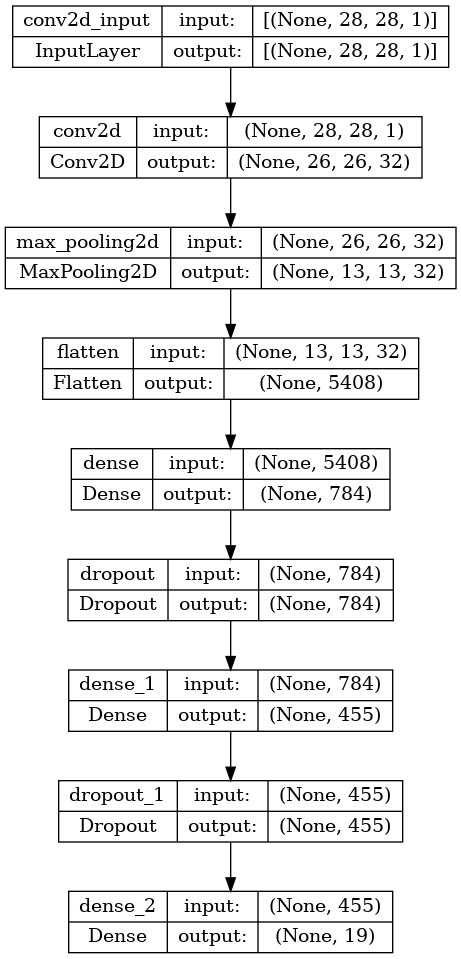

In [ ]:
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

best_model_plot = hyperband_tunner.get_best_models()[0]
plot_model(best_model_plot, to_file="model.png", show_shapes=True, show_layer_names=True)

Comme on peut le voir ce sont les modèles qui ont le plus de couches qui sont les plus performants.

C'est une heuristique que l'on avait évoqué en cours et il n'y a rien de très étonnant à cela.

On remarque l'absence de `dense_3` ce qui signifie que ce n'est pas le nombre maximum de couche qui est le plus optimisé dans notre cas. Cela rentre un peu en contradiction avec ce que nous avions évoqué en cours à que plus on a de couches, plus le modèle est performant.

Voici la liste des hyper paramètes donnants les meilleurs résultats.

In [ ]:
pd.DataFrame(best_hyperparameters.values,index=[0])

,dropout,dropout_first,num_layers,dense_1,dropout_1,dense_2,dropout_2,tuner/epochs,tuner/initial_epoch,tuner/bracket,tuner/round
0,True,0.102735,2,455,0.319693,439,0.205902,4,0,0,0


#### Meilleur nombre d'epochs 📅

Cependant le nombre d'épochs étant défini à la main pour pouvoir explorer les hypers paramètres dans un temps raisonable, il est encore possible d'entrainer le modèle.

Nous allons donc entrainer notre modèle jusqu'a ce que la fonction d'early stoping s'active :

In [ ]:
best_model_epochs_section_label = best_model_section_label + "-epochs"

In [ ]:
def fit(model, x, y, epochs, section_label, validation_split=0.2):
    log_dir = get_log_directory(section_label)
    
    early_stoping_callback = get_early_stoping()
    tensorboard_callback = get_tensorboard_callback(log_dir)
    callbacks = [tensorboard_callback, early_stoping_callback]

    model.fit(
        x,
        y,
        epochs=epochs,
        batch_size=256,
        validation_split=validation_split,
        callbacks=callbacks)

In [ ]:
fit(best_model, x_train_fixed, y_train_fixed, 60, best_model_epochs_section_label)

Epoch 1/60
278/278 [==============================] - 19s 69ms/step - loss: 0.4985 - accuracy: 0.6149 - val_loss: 0.3174 - val_accuracy: 0.9019
Epoch 2/60
278/278 [==============================] - 23s 81ms/step - loss: 0.4797 - accuracy: 0.6200 - val_loss: 0.3061 - val_accuracy: 0.9057
Epoch 3/60
278/278 [==============================] - 22s 78ms/step - loss: 0.4583 - accuracy: 0.6272 - val_loss: 0.2948 - val_accuracy: 0.9049
Epoch 4/60
278/278 [==============================] - 21s 76ms/step - loss: 0.4405 - accuracy: 0.6298 - val_loss: 0.2845 - val_accuracy: 0.9084
Epoch 5/60
278/278 [==============================] - 21s 75ms/step - loss: 0.4264 - accuracy: 0.6341 - val_loss: 0.2804 - val_accuracy: 0.9105
Epoch 6/60
278/278 [==============================] - 21s 76ms/step - loss: 0.4056 - accuracy: 0.6392 - val_loss: 0.2716 - val_accuracy: 0.9120
Epoch 7/60
278/278 [==============================] - 21s 76ms/step - loss: 0.3961 - accuracy: 0.6429 - val_loss: 0.2637 - val_accuracy:

In [ ]:
evaluate(best_model, x_test_fixed, y_test_fixed)

116/116 [==============================] - 1s 7ms/step - loss: 0.2936 - accuracy: 0.9097
Test loss: 0.29361987113952637
Test accuracy: 0.9097297191619873


On peut voir que d'après la fonction d'`EarlyStopping` le nombre d'`epochs` optimal est `33`.

On peut également noter une valeur de `test accuracy` correcte.

On peut cependant noter que la meilleure `accuracy` d'évaluation correspond à `9` `epochs`. Il aurait donc fallu entraîner notre modèle sur `9` `epochs` pour obtenir de meilleurs performances.

# 2 Des chiffres et des lettres

### Chargement des données 💾

In [ ]:
from tensorflow.keras.datasets import mnist

from matplotlib import pyplot as plt

numbers = list(range(0, 10))
print(numbers)

# load dataset
(x_train_number_unprocessed, y_train_number_unprocessed), (x_test_number_unprocessed, y_test_number_unprocessed) = mnist.load_data()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
(x_train_number, y_train_number) = preprocess_data(x_train_number_unprocessed, y_train_number_unprocessed, 10)
(x_test_number, y_test_number) = preprocess_data(x_test_number_unprocessed, y_test_number_unprocessed, 10)

print_shape(x_train_number, y_train_number, x_test_number, y_test_number)

Train: x=(60000, 28, 28), y=(60000, 10)
Test: x=(10000, 28, 28), y=(10000, 10)


### Exploration 🧭

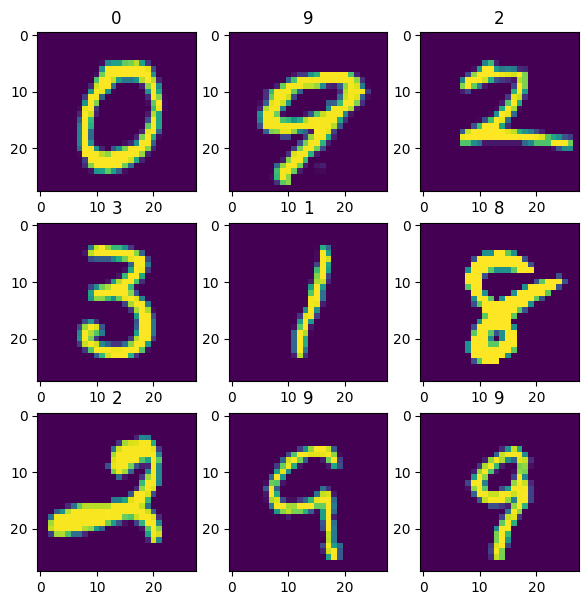

In [ ]:
plot_9_random_images(x_train_number, y_train_number, numbers)

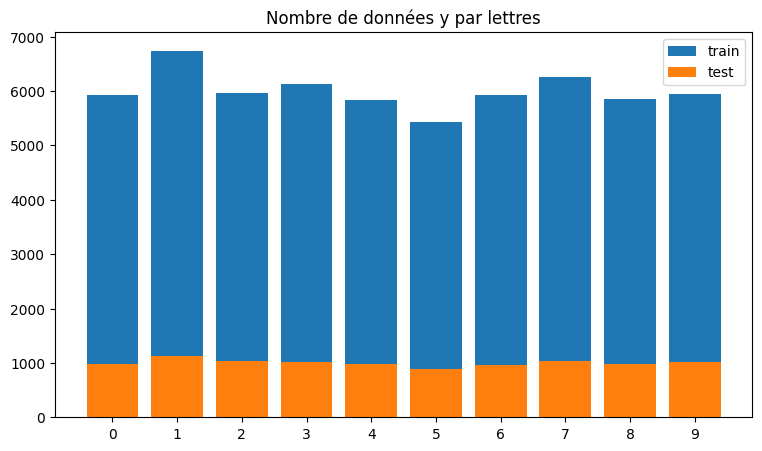

In [ ]:
plot_train_vs_test(y_train_number, y_test_number, numbers)

In [ ]:
print("Numbers:")
print_shape(x_train_number, y_train_number, x_test_number, y_test_number)
print("Letters:")
print_shape(x_train_fixed, y_train_fixed, x_test_fixed, y_test_fixed)

Numbers:
Train: x=(60000, 28, 28), y=(60000, 10)
Test: x=(10000, 28, 28), y=(10000, 10)
Letters:
Train: x=(88800, 28, 28), y=(88800, 19)
Test: x=(14800, 28, 28), y=(14800, 19)


### Fusion 🔀 et preprocess des données 🧮

Vu que l'on ne veut classer que dans 2 catégories, ils nous faut mettre à jour les labels de nos données.

In [ ]:
number_or_letter = ["letters", "number"]

def preprocess_data_number_letters(x, y, categorical_count=26):    
    x = shape_data(x)
    y = categorize_data(y, categorical_count)
    return x, y

def reclass(y, is_fist_class: bool = True):
    if is_fist_class:
        return np.zeros(y.shape)
    else:10000, 28, 28), y=(10000, 10
        return np.ones(y.shape)

def merge_letters_and_numbers(letter, number):
    return np.concatenate((
    letter,
    number))

def preprocess_letters_and_numbers(
    x_letter,
    x_number,
    y_letter,
    y_number,
):
    # Reclass letters
    y_letter_reclassified = reclass(y_letter, True)
    # Reclass numbers
    y_number_reclassified = reclass(y_number, False)
    
    x_letter_shaped = shape_data(x_letter)
    x_number_shaped = shape_data(x_number)

    # Merge numbers and letters
    # train
    x = merge_letters_and_numbers(
        x_letter_shaped,
        x_number_shaped)

    y_number_letter_uncategorized = merge_letters_and_numbers(
        y_letter_reclassified,
        y_number_reclassified)

    y = categorize_data(y_number_letter_uncategorized, 2)
    return x, y

In [ ]:
y_train_letter_number.shape, y_test_letter_number.shape

((148800, 2), (74800, 2))

In [ ]:
x_train_letter_number, y_train_letter_number = preprocess_letters_and_numbers(
    x_train_unprocessed,
    x_train_number_unprocessed,
    y_train_unprocessed,
    y_train_number_unprocessed)
x_test_letter_number, y_test_letter_number = preprocess_letters_and_numbers(
    x_test_unprocessed,
    x_test_number_unprocessed,
    y_test_unprocessed,
    y_test_number_unprocessed)

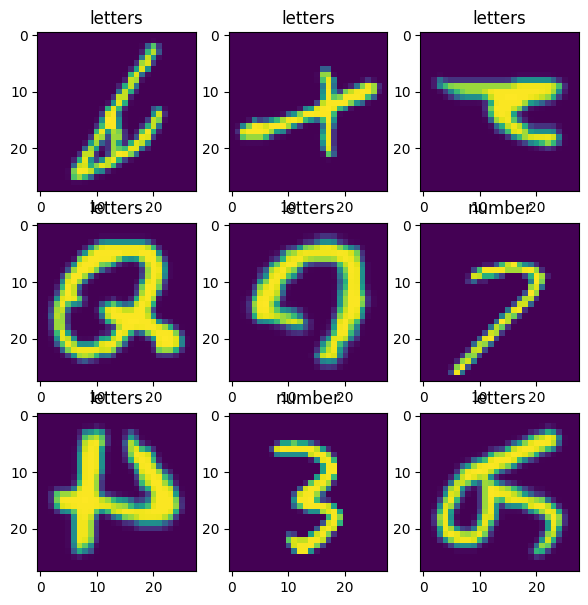

In [ ]:
plot_9_random_images(x_train_letter_number, y_train_letter_number, number_or_letter)

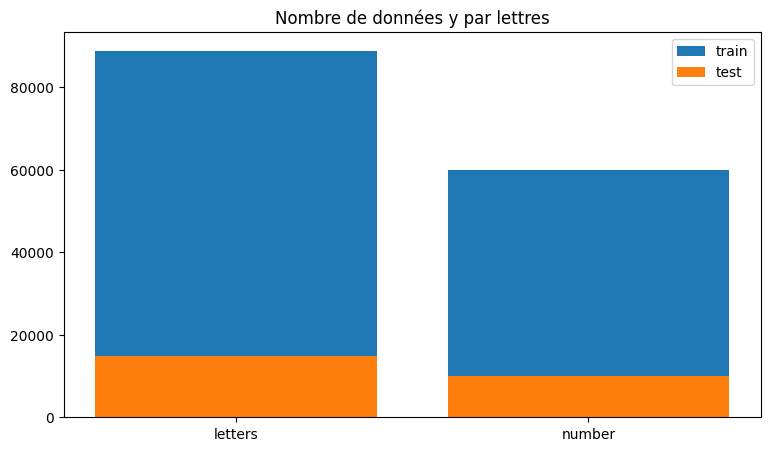

In [ ]:
plot_train_vs_test(y_train_letter_number, y_test_letter_number, number_or_letter)

On remarque une différence entre le nombre de données d'entraînement pour les lettres et pour les chiffres qui déséquilibre un peu le jeu de données. Cela reste cependant cohérent par rapport au nombre de lettre (19) et de chiffres (10) qui constituent notre jeu de données.

### Modèle 🚀

Nous allons utiliser la meme méthode que dans la partie 1.


In [ ]:
letter_number_section_label = "letter-number-tunner"
letter_number_log_dir = get_log_directory(letter_number_section_label)
print(letter_number_section_label, letter_number_log_dir)

letter-number-tunner .cache/letter-number-tunner/log


In [ ]:
num_classes = len(number_or_letter)
print(num_pixels, num_classes)

784 2


#### Meilleurs hyperparamètres 🥇

In [ ]:
def build_model_letter_number(hp, num_pixels=num_pixels, num_classes=num_classes):
    return build_model(hp, num_pixels, num_classes=num_classes)

In [ ]:
tunner_letter_number = get_hyperband_tunner(
    letter_number_section_label,
    max_epochs=6,
    build_model=build_model_letter_number)

benchmark(
    tunner_letter_number,
    letter_number_log_dir,
    x_train_letter_number,
    y_train_letter_number)

Trial 10 Complete [00h 15m 43s]
val_accuracy: 0.9999327659606934

Best val_accuracy So Far: 1.0
Total elapsed time: 01h 32m 35s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_model_letter_number = tunner_letter_number.get_best_models()[0]
best_hyperparameters_letter_number = tunner_letter_number.get_best_hyperparameters()[0]

In [ ]:
score = best_model_letter_number.evaluate(
    x_test_letter_number,
    y_test_letter_number,
    batch_size=128
)

print("Test loss:", score[0])
print("Test accuracy:", score[1])

194/194 [==============================] - 2s 8ms/step - loss: 0.0047 - accuracy: 0.9990
Test loss: 0.004693709313869476
Test accuracy: 0.9989516139030457


On peut voir que l'`accuracy` d'évaluation de notre modèle est excellente.

Nous pourrions l'entrainer davantage afin de selectioner le meilleur nombre d'`epochs`, cependant nous n'en navons malheureusement pas eu le temps.

Il aurait fallu pour cela laisser la méthode d'`EarlyStopping` arrêter l'entraînement comme fait dans la partie 1.

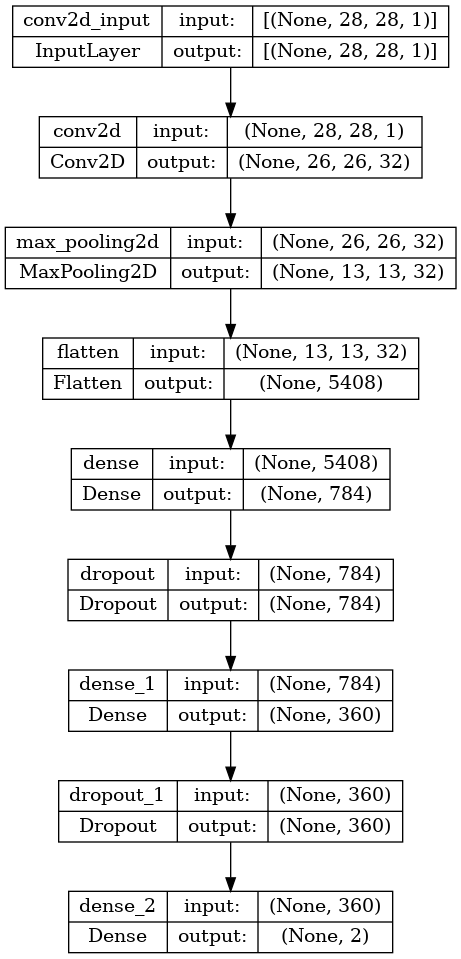

In [ ]:
best_model_letter_number_plot = tunner_letter_number.get_best_models()[0]
plot_model(best_model_letter_number_plot, to_file="letter-number-model.png", show_shapes=True, show_layer_names=True)

On peut noter que le modèle le plus efficace à une architecture similaire à celle de du modèle de classification des lettres.

In [ ]:
pd.DataFrame(best_hyperparameters_letter_number.values,index=[0])

,dropout,dropout_first,num_layers,dense_1,dropout_1,dense_2,dropout_2,tuner/epochs,tuner/initial_epoch,tuner/bracket,tuner/round
0,True,0.40758,2,360,0.230986,502,0.10884,6,0,0,0


Comparons les hyper paramètres actuels, et ceux du modèle de classification des lettres:

In [ ]:
pd.DataFrame({ "Letters and numbers": best_hyperparameters_letter_number.values, "Letters": best_hyperparameters.values})

,Letters and numbers,Letters
dropout,True,True
dropout_first,0.40758,0.102735
num_layers,2,2
dense_1,360,455
dropout_1,0.230986,0.319693
dense_2,502,439
dropout_2,0.10884,0.205902
tuner/epochs,6,4
tuner/initial_epoch,0,0
tuner/bracket,0,0


Nous pouvons voir que le nombre de couches dense cachées supplémentaires est égal pour les 2 modèles. Ce qui est une conclusion attendu, les 2 modèles étant similaires, travaillant sur des données de qualités égales et utilisant le même tuner keras avec la même graine d'aléatoire.

Nous noterons également que le nombre de neurones dans ces couches cachées se situe dans des ordres de grandeurs similaires, probablement pour les raisons évoquées ci-dessus.